In [52]:
import os

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%run model.py
%run betweenCompare.py

%matplotlib inline

np.random.seed(1001)

# Functions 

# Load Data

In [3]:
# Load transformed data
cwd = os.getcwd()
datadir = cwd + os.sep + 'data' + os.sep

data = pd.read_csv(datadir + "complete.csv", index_col = 0)

# Feature Selection

In [4]:
#Drop reputation-based features
data2 = data.drop(["followers_count", "friends_count"], axis = 1)

In [5]:
#Drop highly correlated features
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return(dataset)

#Ignore mv features
mv_cols = list(data.filter(like='mv').columns)
mv_cols
data_mv = data[data.columns.difference(mv_cols)]

data3 = correlation(data_mv, 0.75)

In [7]:
#three models to test the datasets
dt = DecisionTreeClassifier(criterion="entropy")
lr = LogisticRegression()

data_choosers = {'data': data, 'data2': data2, 'data3': data3}

kfolds = KFold(10, True, random_state= 1001)

In [8]:
#Choose data set with highest mean auc
for dataset in data_choosers:
    aucs = list(cross_val_score(dt, data_choosers[dataset].drop('label',1), data_choosers[dataset].label, cv = kfolds, scoring="roc_auc"))
    aucs.extend(cross_val_score(lr, data_choosers[dataset].drop('label',1), data_choosers[dataset].label, cv = kfolds, scoring="roc_auc"))
    
    print("For {0}, mean auc is {1}:".format(dataset, np.round(np.mean(aucs), decimals = 3))) 

For data, mean auc is 0.711:
For data2, mean auc is 0.72:
For data3, mean auc is 0.71:


In [9]:
# Train test split
X_train, X_test, y_train, y_test = ms.train_test_split(data2.drop('label', 1), data2.label, test_size=0.2, random_state=1001)

In [10]:
dt = Model("Decision Tree", DecisionTreeClassifier(criterion="entropy"), X_train, y_train, X_test, y_test)

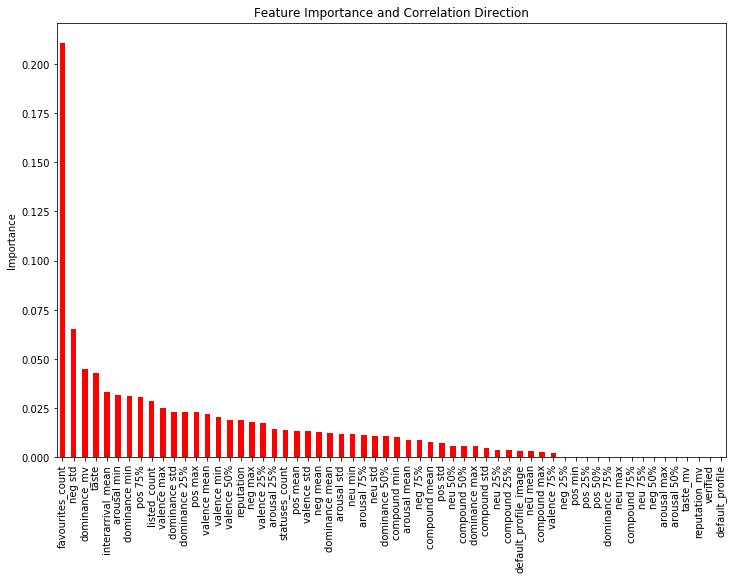

In [11]:
# Get importance and correlation
features_summary = pd.DataFrame(list(zip(X_train.columns, dt.models["Baseline"].model.feature_importances_)), 
                                columns=['feature','importance']).set_index('feature')
features_summary = features_summary.sort_values('importance', ascending=False)

corr_df = pd.DataFrame(data.corr()['label'][:-1])
corr_df.columns = ['correlation']

features_summary = features_summary.merge(corr_df, right_index=True, left_index=True)

# Plot importance and correlation
color_list = ['r' if corr < 0 else 'g' for corr in features_summary.correlation]
features_summary.importance.plot(kind='bar', color=color_list, figsize=(12,8))
plt.title('Feature Importance and Correlation Direction')
plt.ylabel('Importance')

# Select features
keep_features = features_summary[features_summary.importance > 0].index.values

# Train Baseline Model

In [12]:
# Discard features
X_train_filt = X_train[keep_features]
X_test_filt = X_test[keep_features]

#Scale scalable features
scalable = X_train_filt[X_train_filt.columns.difference(mv_cols)].select_dtypes(exclude = ["bool"]).columns
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_filt[scalable].copy())

X_trained = X_train_filt.copy()
X_tested = X_test_filt.copy()


X_trained[scalable] = scaler.transform(X_trained[scalable])
X_tested[scalable] = scaler.transform(X_tested[scalable])

In [13]:
# Baseline Logistic Regression and SVM
lr = Model("Logistic Regression", LogisticRegression(C=1e30), X_trained, y_train, X_tested, y_test)
knn = Model("KNN", KNeighborsClassifier(35), X_trained, y_train, X_tested, y_test)

kfold = KFold(10, True)
lr_cv = cross_val_score(lr.models["Baseline"].model, X_trained, y_train, cv = kfold, scoring="roc_auc")
knn_cv = cross_val_score(knn.models["Baseline"].model, X_trained, y_train, cv = kfold, scoring="roc_auc")

In [14]:
print("LR Mean CV AUC Score: {:0.3}".format(np.mean(lr_cv))+
      "\nLR StdErr CV AUC Score: {:0.3}".format(np.sqrt(np.var(lr_cv)/len(lr_cv))))

print("\nKNN Mean CV AUC Score: {:0.3}".format(np.mean(knn_cv))+
      "\nKNN StdErr CV AUC Score: {:0.3}".format(np.sqrt(np.var(knn_cv)/len(knn_cv))))

LR Mean CV AUC Score: 0.797
LR StdErr CV AUC Score: 0.00956

KNN Mean CV AUC Score: 0.792
KNN StdErr CV AUC Score: 0.0113


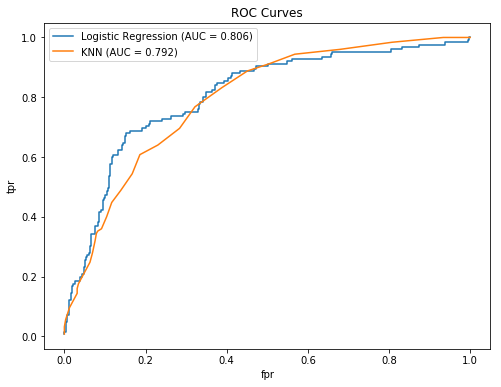

In [16]:
# ROC Curve for single test split baseline models

betweenCompare([lr,knn])

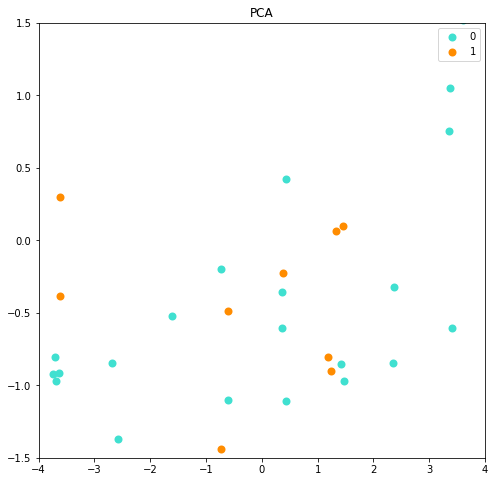

In [24]:
pca = PCA()
X_pca = pca.fit_transform(X_trained)

colors = ['turquoise', 'darkorange']

for X_transformed, title in [(X_pca, "PCA")]:
    plt.figure(figsize=(8, 8))
    for color, i, target_name in zip(colors, [0, 1], np.unique(y_train)):
        plt.scatter(X_transformed[y_train == i, 0], X_transformed[y_train == i, 1],
                    color=color, lw=2, label=target_name)

    plt.title(title)
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.axis([-4, 4, -1.5, 1.5])

plt.show()

# Pipelines

# GBM Tuning 

In [138]:
gbc = Model("GBC", GradientBoostingClassifier(), X_trained, y_train, X_tested, y_test)

 ## Iteration 1

Best Score: 0.857639

Best Params:  {'estimator__n_estimators': 50}


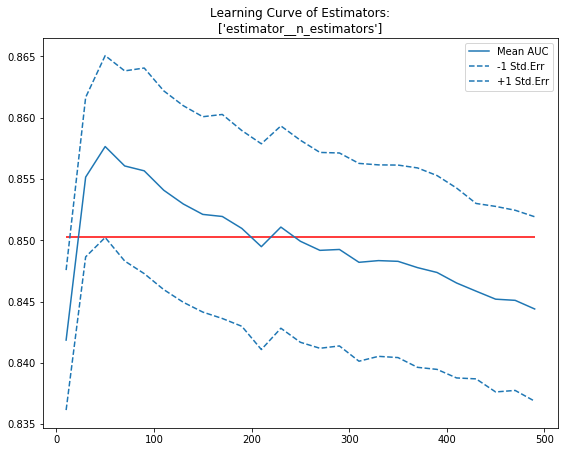

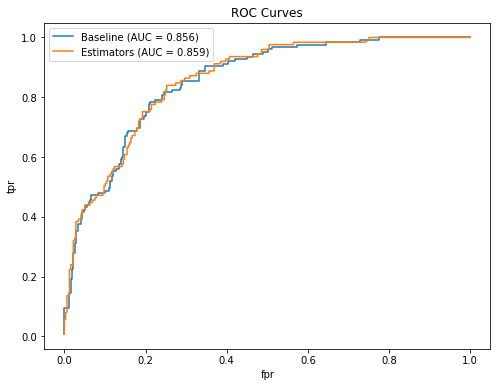

In [139]:
gbc.addIteration("Estimators", GradientBoostingClassifier(),
                {'estimator__n_estimators': list(range(10,500,20))}, plot = True)
gbc.withinCompare()

## Iteration 2 

Best Score: 0.860057

Best Params:  {'estimator__max_depth': 3}


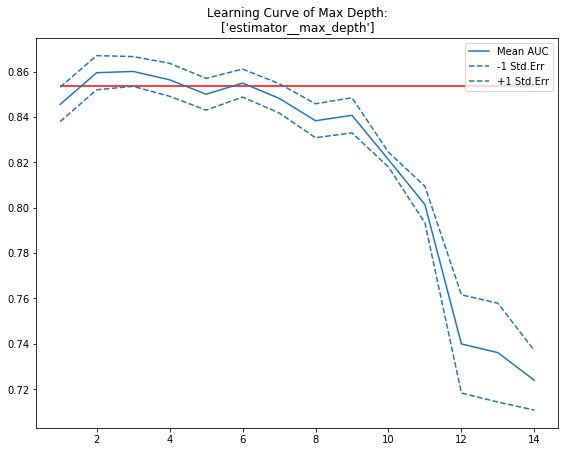

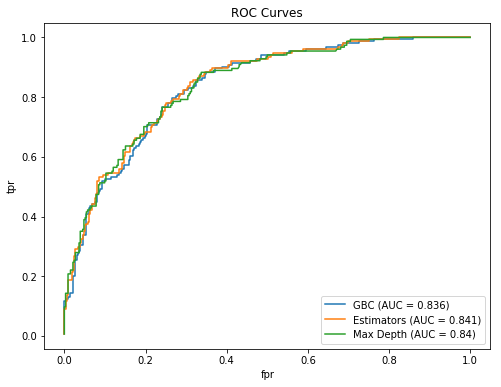

In [27]:
gbc.addIteration("Max Depth", GradientBoostingClassifier(n_estimators=50),
                {'estimator__max_depth': list(range(1,15))}, plot = True)
gbc.withinCompare()

## Iteration 3

Best Score: 0.860272

Best Params:  {'estimator__min_samples_leaf': 135}


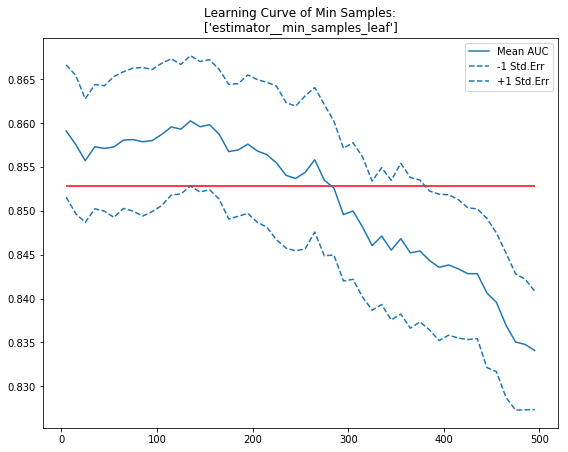

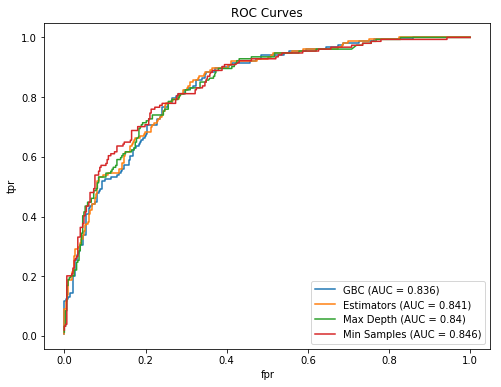

In [51]:
gbc.addIteration("Min Samples", GradientBoostingClassifier(n_estimators=50, max_depth=2),
                {'estimator__min_samples_leaf': list(range(5,500,10))}, plot = True)
gbc.withinCompare()

## Iteration 4

Best Score: 0.859069

Best Params:  {'estimator__max_features': 12}


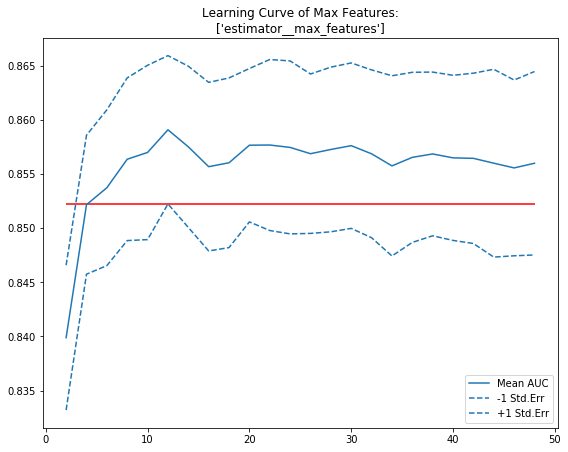

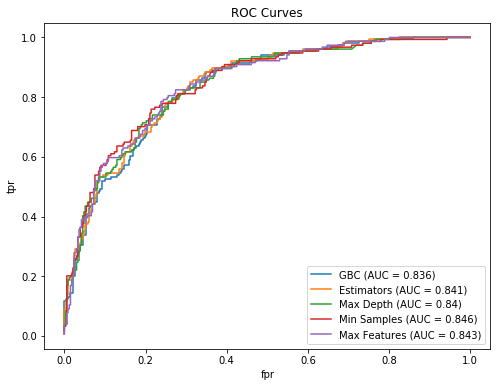

In [52]:
gbc.addIteration("Max Features", GradientBoostingClassifier(n_estimators=50, max_depth=2, min_samples_leaf=215),
                {'estimator__max_features': list(range(2,X_train_filt.shape[1],2))}, plot = True)
gbc.withinCompare()

## Iteration 5

Best Score: 0.858861

Best Params:  {'estimator__subsample': 0.90000000000000002}


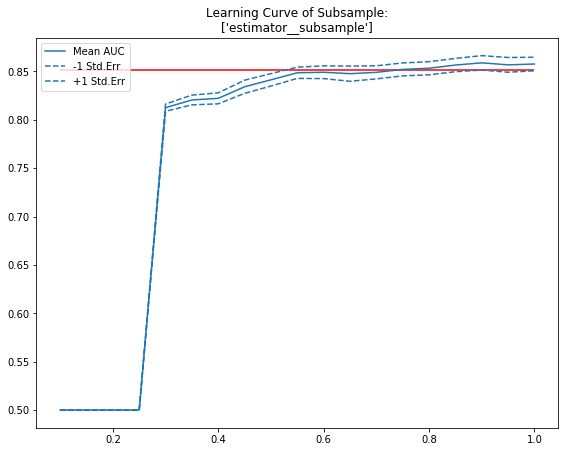

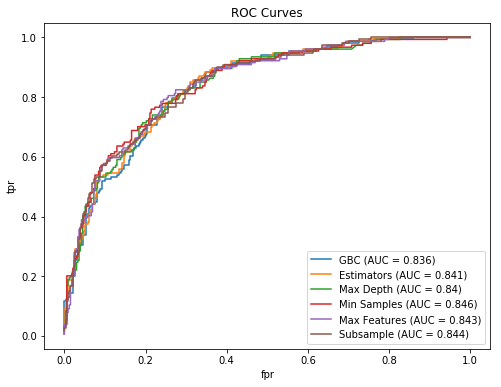

In [54]:
gbc.addIteration("Subsample", 
                GradientBoostingClassifier(n_estimators=50, max_depth=2, min_samples_leaf=215, max_features=14),
                {'estimator__subsample': np.array(list(range(10,105,5)))/100}, plot = True)
gbc.withinCompare()

## Interation 6 

Best Score: 0.866286

Best Params:  {'estimator__learning_rate': 0.1, 'estimator__n_estimators': 210}


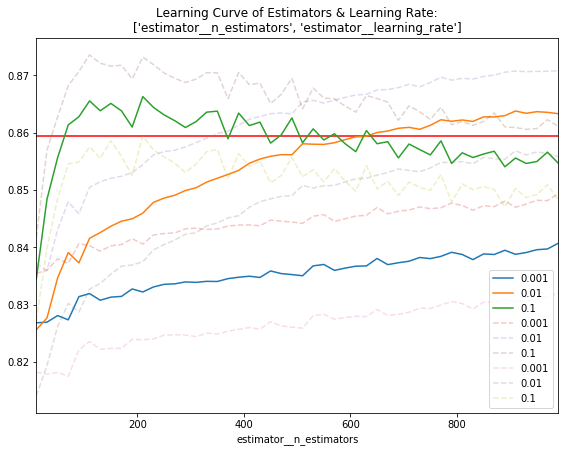

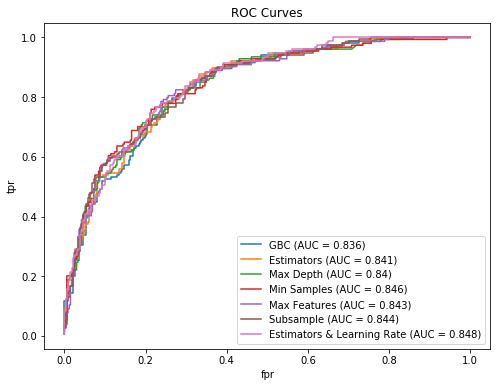

In [55]:
gbc.addIteration("Estimators & Learning Rate",
                GradientBoostingClassifier(n_estimators=50, max_depth=2, min_samples_leaf=215, max_features=14,
                                           subsample=0.85),
                {'estimator__n_estimators': list(range(10,1000,20)),
                 'estimator__learning_rate': [10**x for x in range(-3,0)]}, plot = True)
gbc.withinCompare()

## Iteration 7 

Best Score: 0.854771

Best Params:  {'estimator__n_estimators': 1000}


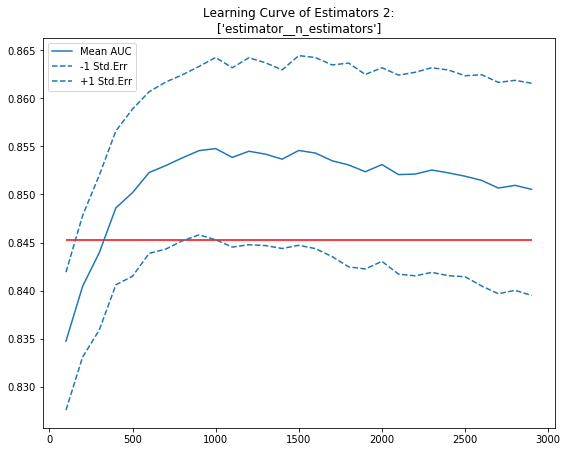

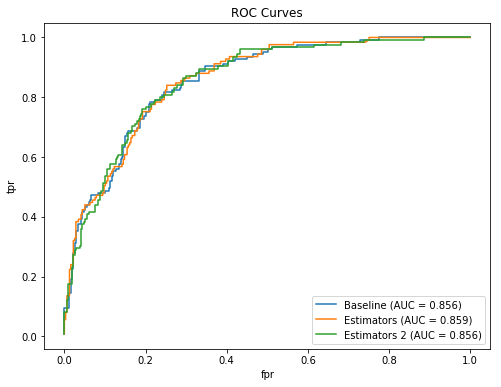

In [140]:
gbc.addIteration("Estimators 2",
                GradientBoostingClassifier(n_estimators=50, max_depth=2, min_samples_leaf=215, max_features=14,
                                           subsample=0.85, learning_rate=0.01),
                {'estimator__n_estimators': list(range(100,3000,100))}, plot = True)
gbc.withinCompare()

# Random Forest



In [92]:
rdf = Model("RDF", RandomForestClassifier(), X_trained, y_train, X_tested, y_test)

## Iteration 1

Best Score: 0.862491

Best Params:  {'estimator__min_samples_leaf': 8}


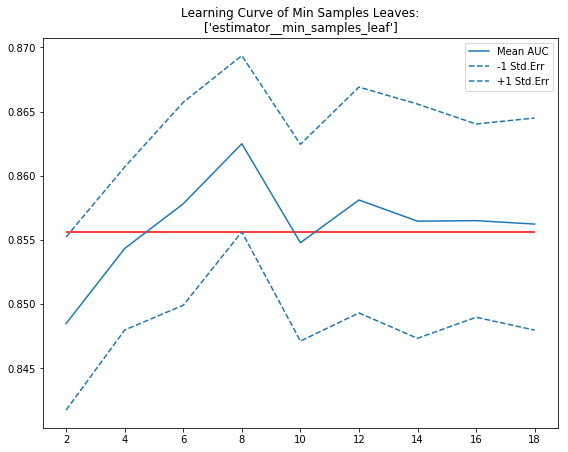

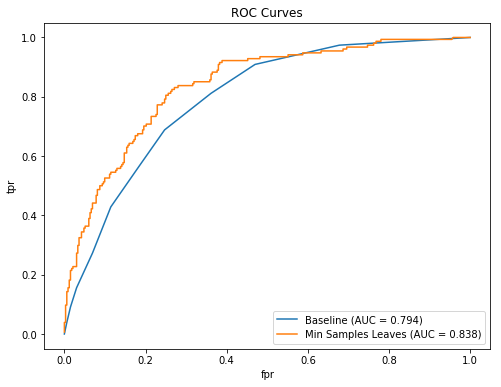

In [93]:
rdf.addIteration("Min Samples Leaves", RandomForestClassifier(n_estimators=25, max_features='auto'),
                {'estimator__min_samples_leaf': list(range(2,20,2))}, plot = True)
rdf.withinCompare()

Best Score: 0.858375

Best Params:  {'estimator__min_samples_split': 3}


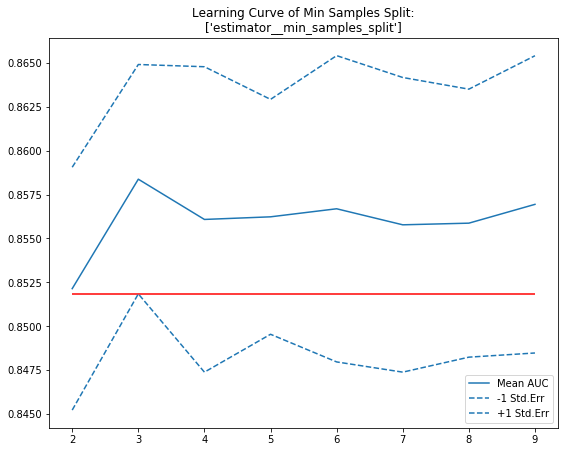

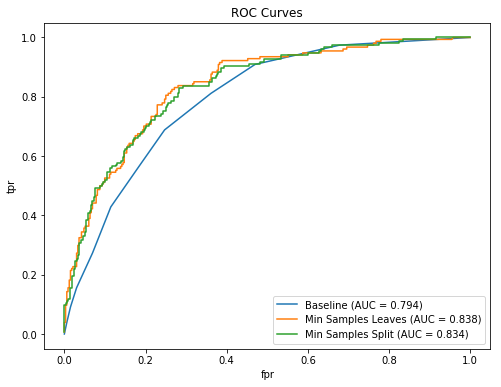

In [94]:
rdf.addIteration("Min Samples Split", RandomForestClassifier(n_estimators=25, max_features='auto', min_samples_leaf = 8),
                {'estimator__min_samples_split':list(range(2,10,1))}, plot = True)
rdf.withinCompare()

# KNN

In [249]:
knn = Model("KNN", KNeighborsClassifier(), X_trained, y_train, X_tested, y_test)

Best Score: 0.792608

Best Params:  {'estimator__n_neighbors': 46}


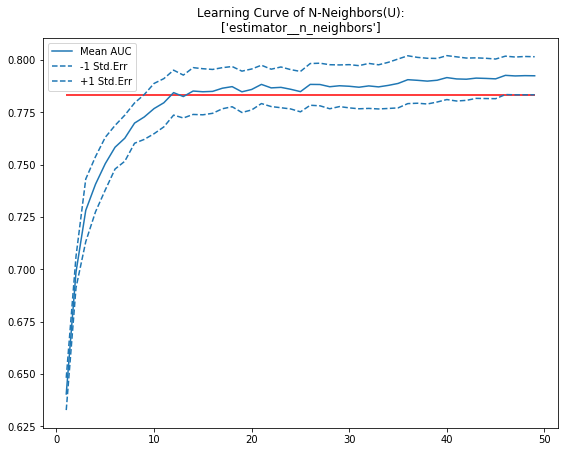

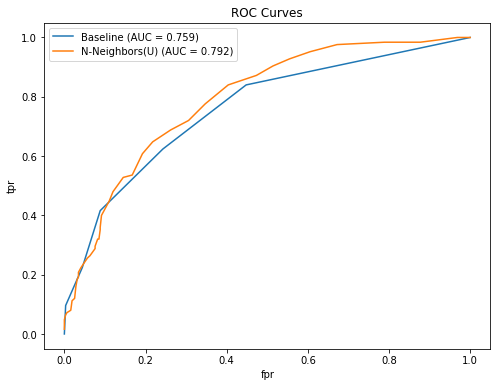

In [250]:
knn.addIteration("N-Neighbors(U)", KNeighborsClassifier(),
                {'estimator__n_neighbors': list(range(1,50,1))}, plot = True)
knn.withinCompare()

Best Score: 0.79366

Best Params:  {'estimator__n_neighbors': 46}


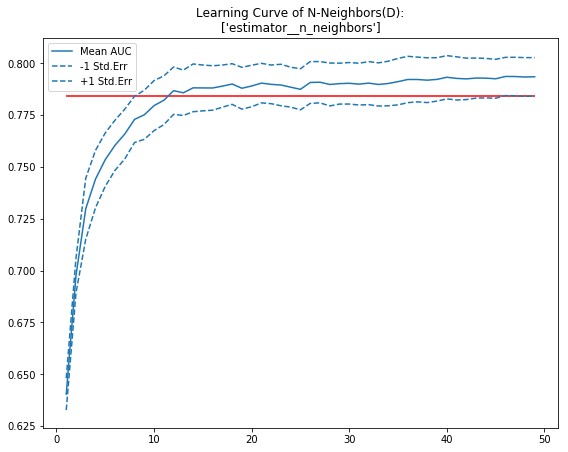

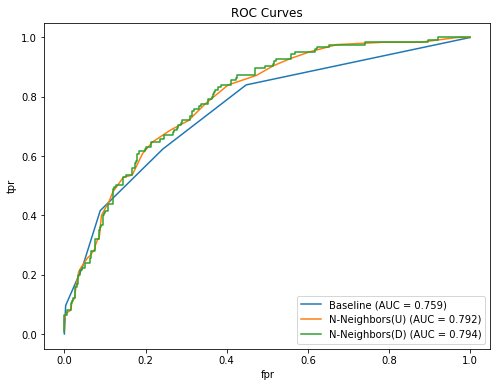

In [251]:
knn.addIteration("N-Neighbors(D)", KNeighborsClassifier(weights = 'distance'),
                {'estimator__n_neighbors': list(range(1,50,1))}, plot = True)
knn.withinCompare()

## Dimension Reduction

In [176]:
boosted = GradientBoostingClassifier()
pca = PCA(whiten = True)

pipe = Pipeline(steps=[('pca', pca), ('boosted', boosted)])

pca.fit(X_trained)

# Prediction
n_components = list(range(1,10))

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components), scoring = "roc_auc", cv = 10)
estimator.fit(X_trained, y_train)

#features = estimator.best_estimator_.named_steps['pca'].n_components
#X_train_pca = pd.DataFrame(pca.fit(X_trained).transform(X_trained.copy()))
#X_text_pca = pd.DataFrame(pca.transform(X_test.copy()))

hunch = estimator.predict_proba(X_tested)[:,1]
hunch_fpr, hunch_tpr, _ = mt.roc_curve(y_test, hunch)
hunch_auc = mt.auc(hunch_fpr, hunch_tpr)
hunch_auc

0.81294637223974764

# Model Comparison


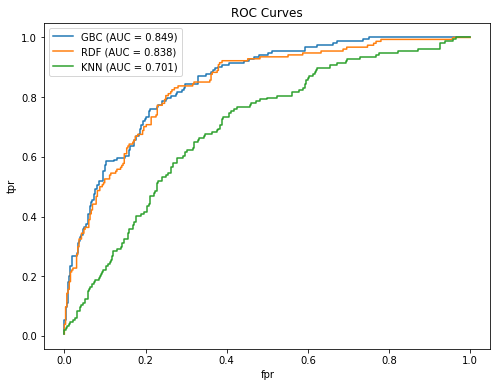

In [102]:
betweenCompare([gbc, rdf, knn])